## Setting Up:

In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import warnings
from tqdm.notebook import tqdm
import re
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import torch.nn as nn
from skorch.helper import SliceDataset
from datetime import datetime
from skorch.callbacks import EarlyStopping, LRScheduler, Checkpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset
import pickle 

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.nn_helpers import *
from scripts.xgb_helpers import *
from scripts.NN_networks import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

# Initialize logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)
colors = get_cmap_hex(cm.batlow, 10)
color_dark_blue = colors[0]
color_pink = '#c51b7d'

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    "millan_v",
]

In [3]:
seed_all(cfg.seed)

if torch.cuda.is_available():
    print("CUDA is available")
    free_up_cuda()

    # # Try to limit CPU usage of random search
    # torch.set_num_threads(2)  # or 1
    # os.environ["OMP_NUM_THREADS"] = "1"
    # os.environ["MKL_NUM_THREADS"] = "1"
else:
    print("CUDA is NOT available")


CUDA is available


## A. Read GL data:

In [ ]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns


Number of glaciers: 32
Number of winter, summer and annual samples: 6275
Number of annual samples: 3184
Number of winter samples: 3091
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

## Input data:
### Input dataset:

In [ ]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file = 'NOR_dataset_monthly_full_with_millanv.csv')
data_monthly = dataloader_gl.data
"""
data_monthly['GLWD_ID'] = data_monthly.apply(
    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),
    axis=1)
data_monthly['GLWD_ID'] = data_monthly['GLWD_ID'].astype(str)

dataloader_gl = mbm.dataloader.DataLoader(cfg,
                                          data=data_monthly,
                                          random_seed=cfg.seed,
                                          meta_data_columns=cfg.metaData)
"""

2025-06-30 09:07:48,037 - INFO - Loaded preprocessed data.
2025-06-30 09:07:48,039 - INFO - Number of monthly rows: 90810
2025-06-30 09:07:48,052 - INFO - Number of annual samples: 54121
2025-06-30 09:07:48,059 - INFO - Number of summer samples: 12747
2025-06-30 09:07:48,066 - INFO - Number of winter samples: 23942


'\ndata_monthly[\'GLWD_ID\'] = data_monthly.apply(\n    lambda x: mbm.data_processing.utils.get_hash(f"{x.GLACIER}_{x.YEAR}"),\n    axis=1)\ndata_monthly[\'GLWD_ID\'] = data_monthly[\'GLWD_ID\'].astype(str)\n\ndataloader_gl = mbm.dataloader.DataLoader(cfg,\n                                          data=data_monthly,\n                                          random_seed=cfg.seed,\n                                          meta_data_columns=cfg.metaData)\n'

## Blocking on glaciers:

In [ ]:
## find RGIId of Glaciers Kamilla used as test set

glacier_list_df = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw +'glaciological_point_mass_balance_Norway.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# breid ids that Kamilla used as test set
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]


breid_to_rgiid = {}
for breid in breid_list:
    matching_row = glacier_list_df[glacier_list_df['breid'] == breid]
    rgiid = matching_row['rgiid'].iloc[0]
    breid_to_rgiid[breid] = rgiid


# Display the mapping
print("Mapping from breid to RGI ID:")
for breid, rgiid in breid_to_rgiid.items():
    print(f"{breid}: {rgiid}")

# Create a list of just the RGI IDs for easy use
test_rgiids = list(breid_to_rgiid.values())
print("\nList of test RGI IDs:")
print(test_rgiids)

rgi_to_glacier = {}

for rgi_id in test_rgiids:
    matching_rows = data_NOR[data_NOR['RGIId'] == rgi_id]
    glacier_name = matching_rows['GLACIER'].iloc[0]
    rgi_to_glacier[rgi_id] = glacier_name


print("RGI ID to Glacier Name mapping:")
for rgi_id, glacier_name in rgi_to_glacier.items():
    print(f"{rgi_id}: {glacier_name}")

norway_kamilla_glacierlist = list(rgi_to_glacier.values())
print("\nList of test RGI IDs:")
print(norway_kamilla_glacierlist)

Size of test data: 14997
Size of train data: 75813
Percentage of test size: 19.78%
Train glaciers: (7) ['FR4N01235A08 dArgentiere' 'FR4N01236A01 Mer de Glace/Geant'
 'FR4N01236A01 Leschaux' 'FR4N01236A07 de Talefre'
 'FR4N01163A02 de Sarennes 1' 'FR4N01162B09+154D03 de Saint Sorlin'
 'FR4N01236A02 des Grands Montets']
Test glaciers: (1) ['FR4N01146D09+E06 Gebroulaz']


In [ ]:
"""
test_glaciers = [
    'Vestre Memurubreen', 'Rembesdalskaaka',
    'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
    'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
    'Blomstoelskardsbreen'
]
"""
test_glaciers = norway_kamilla_glacierlist.copy()

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

In [ ]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## B. CH Transfer

In [4]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm_with_millanv.csv')

# Drop Nan entries in millan_v of Norway dataset
data_NOR = data_NOR.dropna(subset=data_NOR.columns.drop('DATA_MODIFICATION'))
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))


,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
7,67.31103,16.04244,942,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.321560,56.485962,69.698883
8,67.30629,16.05432,1089,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.424430,147.849106,13.431213
9,67.30809,16.07252,1093,20120925,20130927,-3.02,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30809_16.07252_N_...,38.497514,3.836923,1090.195312,-1.584609,128.302780,31.785975
10,67.29883,16.08302,1153,20120925,20130927,-3.56,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29883_16.08302_N_...,355.618198,3.476761,1152.887817,-1.078567,118.048553,55.155796
11,67.29155,16.06082,1256,20120925,20130927,-2.51,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.29155_16.06082_N_...,349.840923,1.787641,1254.803467,-1.107427,258.436462,26.527679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6269,61.74291,7.14345,1796,19611001,19620513,2.38,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.74291_7.14345_N_N_...,181.776838,7.609763,1793.964722,-0.510832,176.193283,14.855300
6270,61.69387,7.11652,1579,19611001,19620513,2.76,winter,RGI60-08.01126,1962,Nigardsbreen,Filled missing FROM_DATE with October 1st of p...,Nigardsbreen_1962_winter_61.69387_7.11652_N_N_...,81.210212,13.313894,1570.454346,-0.178745,125.875511,22.823906
6272,68.33479,17.85005,1092,19661020,19670520,1.86,winter,RGI60-08.02436,1967,Blaaisen,Changed TO_DATE year fomr 1966 to 1967,Blaaisen_1967_winter_68.33479_17.85005_N_N_4155,29.882699,17.255500,1050.585938,-1.058776,36.787617,43.074333
6273,61.71461,7.11601,1587,19631001,19640507,2.01,winter,RGI60-08.01126,1964,Nigardsbreen,Changed TO_DATE year fomr 1963 to 1964,Nigardsbreen_1964_winter_61.71461_7.11601_N_N_...,151.305943,4.883604,1586.242676,-1.184982,197.545349,35.713974


Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'],
      dtype='object')

Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v'],
      dtype='object')

Index(['YEAR', 'POINT_ID', 'GLACIER', 'FROM_DATE', 'TO_DATE', 'POINT_LAT',
       'POINT_LON', 'POINT_ELEVATION', 'POINT_BALANCE', 'PERIOD', 'RGIId',
       'aspect', 'slope', 'topo', 'hugonnet_dhdt', 'consensus_ice_thickness',
       'millan_v'],
      dtype='object')

,POINT_LAT,POINT_LON,POINT_ELEVATION,FROM_DATE,TO_DATE,POINT_BALANCE,PERIOD,RGIId,YEAR,GLACIER,DATA_MODIFICATION,POINT_ID,aspect,slope,topo,hugonnet_dhdt,consensus_ice_thickness,millan_v
0,67.31103,16.04244,942.0,20120925,20130927,-5.63,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,303.724524,17.264116,946.701050,-2.32156,56.485962,69.698883
1,67.30629,16.05432,1089.0,20120925,20130927,-3.83,annual,RGI60-08.02384,2013,Rundvassbreen,NaN,Rundvassbreen_2013_annual_67.30629_16.05432_N_...,332.405609,2.198246,1088.740723,-1.42443,147.849106,13.431213


70

In [5]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full_with_millanv.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

2025-07-07 07:53:07,402 - INFO - Number of annual and seasonal samples: 39317
2025-07-07 07:53:07,406 - INFO - Running on 70 glaciers:
['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Nigardsbreen'
 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen' 'Rembesdalskaaka'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memurubreen'
 'Vestre Memurubreen' 'Hoegtuvbreen' 'Bondhusbrea' 'adler' 'albigna'
 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen' 'clariden'
 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro' 'gorner'
 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel' 'oberaar'
 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna' 'sardona'
 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta' 't

2025-07-07 07:53:07,472 - INFO - Number of winter samples: 28989
2025-07-07 07:53:07,473 - INFO - Adding climate features...
2025-07-07 07:53:32,712 - INFO - Converting to monthly resolution...
2025-07-07 07:54:59,378 - INFO - Number of monthly rows: 347647
2025-07-07 07:54:59,379 - INFO - Columns in the dataset: Index(['YEAR', 'POINT_LON', 'POINT_LAT', 'POINT_BALANCE', 'ALTITUDE_CLIMATE',
       'ELEVATION_DIFFERENCE', 'POINT_ELEVATION', 'RGIId', 'POINT_ID', 'ID',
       'N_MONTHS', 'MONTHS', 'PERIOD', 'GLACIER', 'aspect', 'slope',
       'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp',
       'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'],
      dtype='object')
2025-07-07 07:55:06,562 - INFO - Processed data saved to: /home/mburlet/scratch/data/DATA_MB/WGMS/Norway/csv/CH_NOR_wgms_dataset_monthly_full_with_millanv.csv


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,millan_v,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-3.957367,0.002545,-120958.0,132238.0,2673505.0,0.518889,-2003158.0,-0.577771,0.414947
1,2013,16.04244,67.31103,-5.63,930.332494,11.667506,942.0,RGI60-08.02384,Rundvassbreen_2013_annual_67.31103_16.04244_N_...,0,...,69.698883,-7.107025,0.003408,107086.0,467112.0,414668.0,0.838310,-1135388.0,-1.247729,1.351297


In [6]:
test_glaciers = list(data_NOR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


Size of test data: 56965
Size of train data: 290682
Percentage of test size: 19.60%
Train glaciers: (39) ['adler' 'albigna' 'aletsch' 'allalin' 'basodino' 'cantun' 'chessjen'
 'clariden' 'corbassiere' 'corvatsch' 'damma' 'findelen' 'forno' 'gietro'
 'gorner' 'gries' 'hohlaub' 'joeri' 'limmern' 'morteratsch' 'murtel'
 'oberaar' 'otemma' 'pizol' 'plainemorte' 'plattalva' 'rhone' 'sanktanna'
 'sardona' 'schwarzbach' 'schwarzberg' 'sexrouge' 'silvretta'
 'taelliboden' 'tiefen' 'tortin' 'tsanfleuron' 'vorab' 'witenwasseren']
Test glaciers: (31) ['Rundvassbreen' 'Engabreen' 'Aalfotbreen' 'Hansebreen' 'Nigardsbreen'
 'Austdalsbreen' 'Juvfonne' 'Hellstugubreen' 'Rembesdalskaaka'
 'Svelgjabreen' 'Blomstoelskardsbreen' 'Moesevassbrea'
 'Storsteinsfjellbreen' 'Svartisheibreen' 'Trollbergdalsbreen'
 'Vetlefjordbreen' 'Harbardsbreen' 'Storglombreen N' 'Graafjellsbrea'
 'Breidablikkbrea' 'Graasubreen' 'Blaaisen' 'Blabreen' 'Ruklebreen'
 'Cainhavarre' 'Tunsbergdalsbreen' 'Vesledalsbreen' 'Austre Memu

In [7]:
# Validation and train split:
data_train = train_set['df_X']
data_train['y'] = train_set['y']
dataloader = mbm.dataloader.DataLoader(cfg, data=data_train)

train_itr, val_itr = dataloader.set_train_test_split(test_size=0.2)

# Get all indices of the training and valing dataset at once from the iterators. Once called, the iterators are empty.
train_indices, val_indices = list(train_itr), list(val_itr)

df_X_train = data_train.iloc[train_indices]
y_train = df_X_train['POINT_BALANCE'].values

# Get val set
df_X_val = data_train.iloc[val_indices]
y_val = df_X_val['POINT_BALANCE'].values

## Neural Network:

In [8]:
def create_period_indicator(df):
    """Create numerical PERIOD_INDICATOR feature"""
    df = df.copy()
    df['PERIOD_INDICATOR'] = df['PERIOD'].map({'annual': 0, 'winter': 1})
    return df

# Apply to all datasets
df_X_train = create_period_indicator(df_X_train)
df_X_val = create_period_indicator(df_X_val)
test_set['df_X'] = create_period_indicator(test_set['df_X'])

print("PERIOD_INDICATOR created:")
print("Annual (0):", (df_X_train['PERIOD_INDICATOR'] == 0).sum())
print("Winter (1):", (df_X_train['PERIOD_INDICATOR'] == 1).sum())
print("Original PERIOD column preserved:", df_X_train['PERIOD'].unique())

PERIOD_INDICATOR created:
Annual (0): 70279
Winter (1): 162367
Original PERIOD column preserved: ['annual' 'winter']


In [9]:
features_topo = [
    'ELEVATION_DIFFERENCE',
] + list(vois_topographical)

# Add PERIOD_INDICATOR as a feature (keeping original PERIOD for plotting)
feature_columns = features_topo + list(vois_climate) + ['PERIOD_INDICATOR']

cfg.setFeatures(feature_columns)

all_columns = feature_columns + cfg.fieldsNotFeatures

# Because CH has some extra columns, we need to cut those
df_X_train_subset = df_X_train[all_columns]
df_X_val_subset = df_X_val[all_columns]
df_X_test_subset = test_set['df_X'][all_columns]

print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of validation dataset:', df_X_val_subset.shape)
print('Shape of testing dataset:', df_X_test_subset.shape)
print('Running with features:', feature_columns)

assert all(train_set['df_X'].POINT_BALANCE == train_set['y'])

Shape of training dataset: (232646, 29)
Shape of validation dataset: (58036, 29)
Shape of testing dataset: (56965, 29)
Running with features: ['ELEVATION_DIFFERENCE', 'aspect', 'slope', 'hugonnet_dhdt', 'consensus_ice_thickness', 'millan_v', 't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10', 'PERIOD_INDICATOR']


In [16]:
# Check the current Iceland feature order
print("Current Norway feature order:")
for i, feature in enumerate(feature_columns):
    print(f"{i}: {feature}")

Current Norway feature order:
0: ELEVATION_DIFFERENCE
1: aspect
2: slope
3: hugonnet_dhdt
4: consensus_ice_thickness
5: millan_v
6: t2m
7: tp
8: slhf
9: sshf
10: ssrd
11: fal
12: str
13: u10
14: v10
15: PERIOD_INDICATOR


### Initialise network:

In [ ]:
"""
# Open grid_search results
gs_results = pd.read_csv(
        'logs/nn_param_search_progress_2025-06-06.csv').sort_values(
        by='valid_loss', ascending=True)
best_params = gs_results.iloc[0].to_dict()

print('Best parameters from grid search:')
for key, value in best_params.items():
    if key not in ['valid_loss', 'train_loss']:
        print(f"{key}: {value}")

gs_results.head(10)
"""

'\n# Open grid_search results\ngs_results = pd.read_csv(\n        \'logs/nn_param_search_progress_2025-06-06.csv\').sort_values(\n        by=\'valid_loss\', ascending=True)\nbest_params = gs_results.iloc[0].to_dict()\n\nprint(\'Best parameters from grid search:\')\nfor key, value in best_params.items():\n    if key not in [\'valid_loss\', \'train_loss\']:\n        print(f"{key}: {value}")\n\ngs_results.head(10)\n\nprint(f"nInp: {nInp}")\nprint(f"n_features_topo: {len(features_topo)}")\nprint(f"n_features_climate: {len(vois_climate)}")\nprint(f"PERIOD_INDICATOR included: {\'PERIOD_INDICATOR\' in feature_columns}")\n\n# Import the new PeriodSpecificNet model\nfrom scripts.NN_networks import PeriodSpecificNet\n\n# Update model configuration for PeriodSpecificNet\nargs = {\n    \'module\': PeriodSpecificNet,\n    \'nbFeatures\': nInp,\n    \'module__n_features\': nInp,\n    \'module__hidden_dim\': params[\'module__layer0\'],\n    \'module__n_layers\': 3,\n    \'module__dropout\': params[\'

In [ ]:
early_stop = EarlyStopping(
    monitor='valid_loss',
    patience=10,    # Increase from 10
    threshold=1e-4,  # Optional: stop only when improvement is very small
)

lr_scheduler_cb = LRScheduler(policy=ReduceLROnPlateau,
                              monitor='valid_loss',
                              mode='min',
                              factor=0.5,   # Reduced more aggressively (was 0.5)
                              patience=5,   # Reduced patience (was 5)
                              threshold=0.01,  # Reduced threshold (was 0.01)
                              threshold_mode='rel',
                              verbose=True)

dataset = dataset_val = None  # Initialized hereafter
def my_train_split(ds, y=None, **fit_params):
    return dataset, dataset_val


# param_init = {'device': 'cuda:0'}
param_init = {'device': 'cpu'}  # Use CPU for training
nInp = len(feature_columns)


custom_params = {
    'lr': 0.001,    # reduced from 0.001
    'batch_size': 128,  # Increased from 128
    'module__layer0': 128,
    'module__layer1': 96,
    'module__layer2': 64,
    'module__layer3': 32,
    'module__dropout': 0.2,
    'optimizer':torch.optim.Adam
}

params = custom_params

args = {
    'module': PeriodSpecificNetBigger,
    'nbFeatures': nInp,
    'module__input_dim': nInp,
    'module__hidden_dim_0': params['module__layer0'],
    'module__hidden_dim_1': params['module__layer1'], 
    'module__hidden_dim_2': params['module__layer2'],
    'module__hidden_dim_3': params['module__layer3'],
    'train_split': my_train_split,
    'batch_size': params['batch_size'],
    'verbose': 1,
    'iterator_train__shuffle': True,
    'lr': params['lr'],
    'max_epochs': 300,
    'optimizer': params['optimizer'],
    'callbacks': [
        ('early_stop', early_stop),
        ('lr_scheduler', lr_scheduler_cb),
    ]
}
custom_nn = mbm.models.CustomNeuralNetRegressor(cfg, **args, **param_init)

### Create datasets:

In [11]:
features, metadata = custom_nn._create_features_metadata(df_X_train_subset)

features_val, metadata_val = custom_nn._create_features_metadata(
    df_X_val_subset)

# Define the dataset for the NN
dataset = mbm.data_processing.AggregatedDataset(cfg,
                                                features=features,
                                                metadata=metadata,
                                                targets=y_train)
dataset = mbm.data_processing.SliceDatasetBinding(SliceDataset(dataset, idx=0),
                                                  SliceDataset(dataset, idx=1))
print("train:", dataset.X.shape, dataset.y.shape)

dataset_val = mbm.data_processing.AggregatedDataset(cfg,
                                                    features=features_val,
                                                    metadata=metadata_val,
                                                    targets=y_val)
dataset_val = mbm.data_processing.SliceDatasetBinding(
    SliceDataset(dataset_val, idx=0), SliceDataset(dataset_val, idx=1))
print("validation:", dataset_val.X.shape, dataset_val.y.shape)

train: (26686,) (26686,)
validation: (6672,) (6672,)


### Train custom model:

Training the model...
Model parameters:
module: <class 'scripts.NN_networks.PeriodSpecificNetBigger'>
nbFeatures: 16
module__input_dim: 16
module__hidden_dim_0: 128
module__hidden_dim_1: 96
module__hidden_dim_2: 64
module__hidden_dim_3: 32
train_split: <function my_train_split at 0x7134e120b9c0>
batch_size: 128
verbose: 1
iterator_train__shuffle: True
lr: 0.001
max_epochs: 300
optimizer: <class 'torch.optim.adam.Adam'>
callbacks: [('early_stop', <skorch.callbacks.training.EarlyStopping object at 0x7134d1163850>), ('lr_scheduler', <skorch.callbacks.lr_scheduler.LRScheduler object at 0x7134f5810e90>)]
  epoch    train_loss    valid_loss      lr      dur
-------  ------------  ------------  ------  -------
      1        0.9072        0.7335  0.0010  20.3585
      2        0.5220        0.6062  0.0010  19.9337
      3        0.4657        0.5839  0.0010  19.9545
      4        0.4173        0.5433  0.0010  19.7303
      5        0.4043        0.5147  0.0010  20.1235
      6        0.3844 

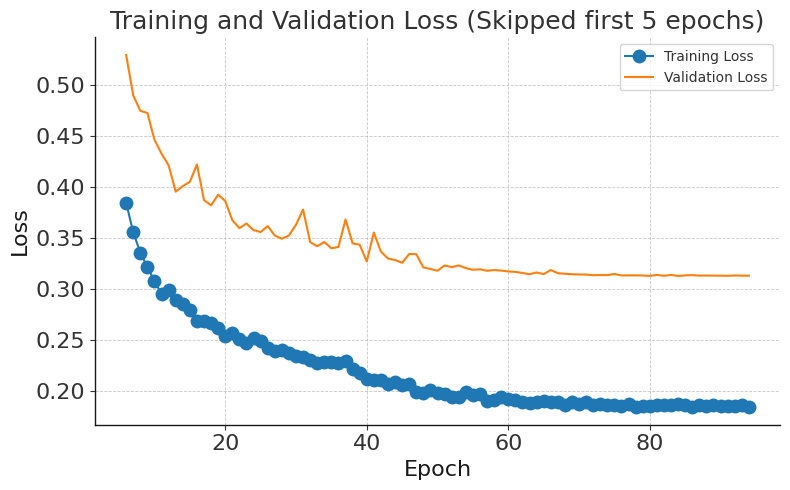

In [12]:
TRAIN = True
if TRAIN:
    custom_nn.seed_all()

    print("Training the model...")
    print('Model parameters:')
    for key, value in args.items():
        print(f"{key}: {value}")
    custom_nn.fit(dataset.X, dataset.y)
    # The dataset provided in fit is not used as the datasets are overwritten in the provided train_split function

    # Generate filename with current date
    current_date = datetime.now().strftime("%Y-%m-%d")
    model_filename = f"nn_model_{current_date}"

    plot_training_history(custom_nn, skip_first_n=5)

    # After Training: Best weights are already loaded
    # Save the model
    custom_nn.save_model(model_filename)
    
    # save params dic
    params_filename = f"nn_params_{current_date}.pkl"

    with open(f"models/{params_filename}", "wb") as f:
        pickle.dump(args, f)

else:
    # Load model and set to CPU
    model_filename = "nn_model_2025-06-17_geb.pt"  # Replace with actual date if needed
    loaded_model = mbm.models.CustomNeuralNetRegressor.load_model(
        cfg,
        model_filename,
        **{
            **args,
            **param_init
        },
    )
    loaded_model = loaded_model.set_params(device='cpu')
    loaded_model = loaded_model.to('cpu')

### Load model and make predictions:

In [14]:
# Create features and metadata
features_test, metadata_test = loaded_model._create_features_metadata(
    df_X_test_subset)

# Ensure all tensors are on CPU if they are torch tensors
if hasattr(features_test, 'cpu'):
    features_test = features_test.cpu()

# Ensure targets are also on CPU
targets_test = test_set['y']
if hasattr(targets_test, 'cpu'):
    targets_test = targets_test.cpu()

# Create the dataset
dataset_test = mbm.data_processing.AggregatedDataset(cfg,
                                                     features=features_test,
                                                     metadata=metadata_test,
                                                     targets=targets_test)

dataset_test = [
    SliceDataset(dataset_test, idx=0),
    SliceDataset(dataset_test, idx=1)
]

# Make predictions aggr to meas ID
y_pred = loaded_model.predict(dataset_test[0])
y_pred_agg = loaded_model.aggrPredict(dataset_test[0])

batchIndex = np.arange(len(y_pred_agg))
y_true = np.array([e for e in dataset_test[1][batchIndex]])

# Calculate scores
score = loaded_model.score(dataset_test[0], dataset_test[1])
mse, rmse, mae, pearson = loaded_model.evalMetrics(y_pred, y_true)

# Aggregate predictions
id = dataset_test[0].dataset.indexToId(batchIndex)
data = {
    'target': [e[0] for e in dataset_test[1]],
    'ID': id,
    'pred': y_pred_agg
}
grouped_ids = pd.DataFrame(data)

# Add period
periods_per_ids = df_X_test_subset.groupby('ID')['PERIOD'].first()
grouped_ids = grouped_ids.merge(periods_per_ids, on='ID')

# Add glacier name
glacier_per_ids = df_X_test_subset.groupby('ID')['GLACIER'].first()
grouped_ids = grouped_ids.merge(glacier_per_ids, on='ID')

# Add YEAR
years_per_ids = df_X_test_subset.groupby('ID')['YEAR'].first()
grouped_ids = grouped_ids.merge(years_per_ids, on='ID')

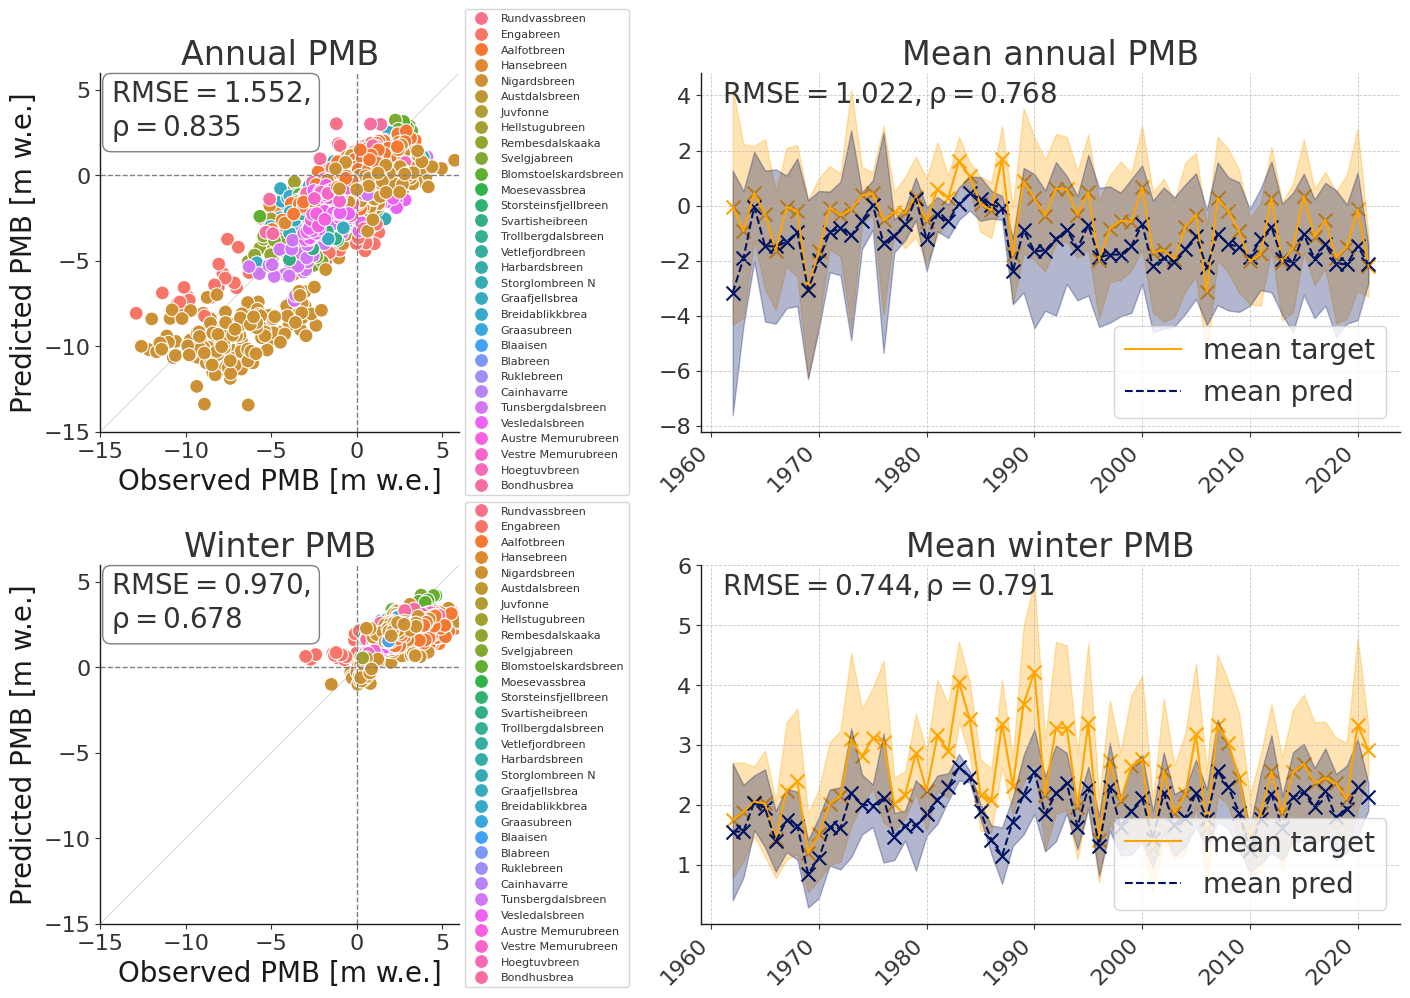

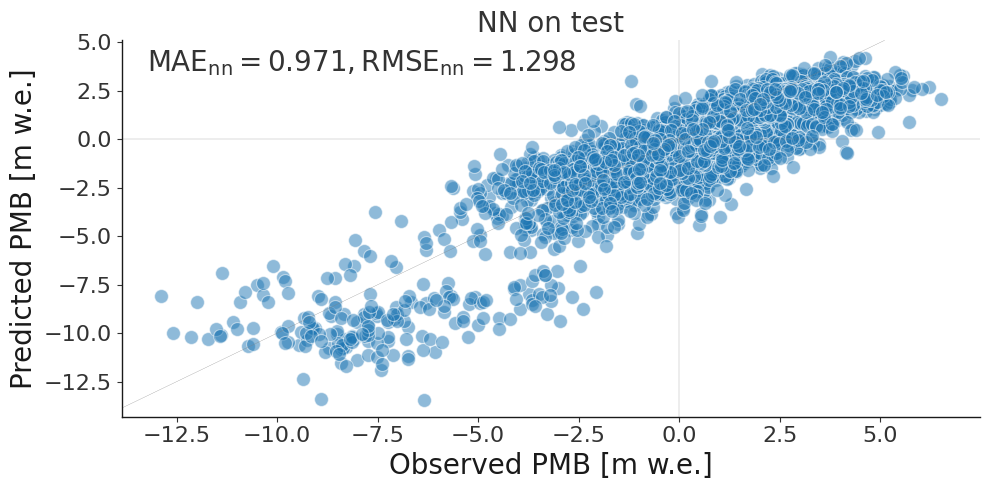

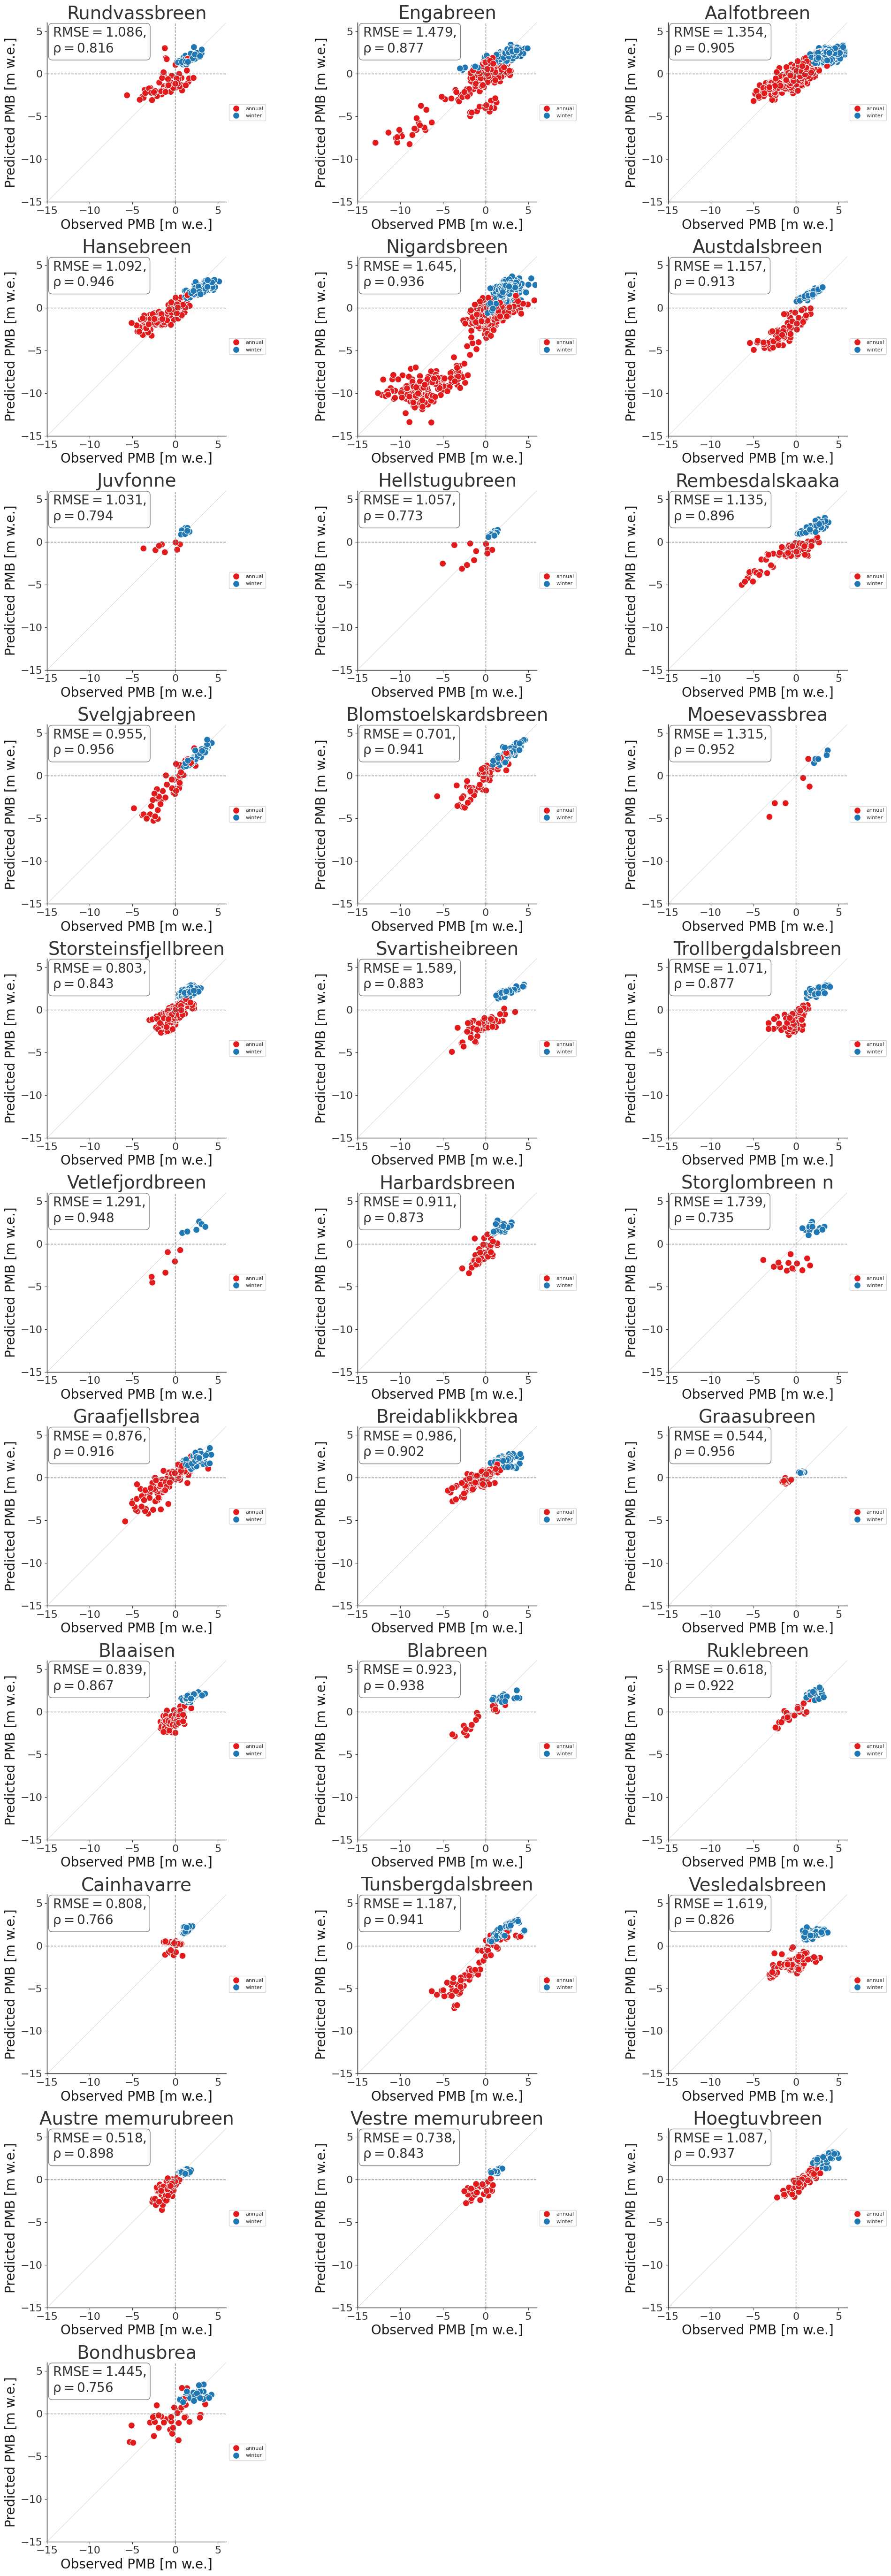

In [15]:
PlotPredictions_NN(grouped_ids)
predVSTruth_all(grouped_ids, mae, rmse, title='NN on test')
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))